In [1]:
# Import packages
import pandas as pd
import numpy as np
import requests

In [2]:
# API
title = ['France_cpi' , 'Germany_cpi' , 'Belgium_cpi' , 'Italy_cpi' , 'Poland_cpi' , 'Spain_cpi' , 'The Netherlands_cpi' , 'Ireland_cpi' , 'Austria_cpi']
series_codes = ['CPALTT01FRM657N' , 'CPALTT01DEM657N' , 'CPALTT01BEM657N' , 'CPALTT01ITM657N' , 'CPALTT01PLM657N' , 'CPALTT01ESM657N' , 'CPALTT01NLM657N' , 'CPALTT01IEM657N' , 'CPALTT01ATM657N']

In [3]:
USD_EUR_exrate = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=DEXUSEU&api_key=ec84959f0124fa43e3b547e8cf788a1a&file_type=json').json()

In [4]:
# Extracting necessary data from API

# Get observations from JSON data store as a pandas dataframe
USD_EUR_exrate_df = pd.DataFrame(USD_EUR_exrate['observations'])
# Change 'value' column containing the USD/EUR exchange rate from a string to a numeric
USD_EUR_exrate_df['value'] = pd.to_numeric(USD_EUR_exrate_df['value'], errors='coerce')
# Convert daily exchange rate data to monthly data
# Remove the day part of the month string
USD_EUR_exrate_df['date'] = USD_EUR_exrate_df['date'].str[:-3]
# Aggregate to monthly by taking the month mean exchange rate
USD_EUR_exrate_df = USD_EUR_exrate_df.groupby(by='date').mean('value').reset_index()
# Change 'date' column from a string to a date
USD_EUR_exrate_df['date'] = pd.to_datetime(USD_EUR_exrate_df['date'], errors='coerce')
# Get the exchange rate in Euros per Dollar instead of Dollars per Euro
USD_EUR_exrate_df['EUR_USD_exrate'] = 1 / USD_EUR_exrate_df['value']
# Subset to relavent columns
EUR_USD_exrate_df = USD_EUR_exrate_df[['date' , 'EUR_USD_exrate']]
EUR_USD_exrate_df

,date,EUR_USD_exrate
0,1999-01-01,0.862742
1,1999-02-01,0.892635
2,1999-03-01,0.918622
3,1999-04-01,0.934536
4,1999-05-01,0.940729
...,...,...
306,2024-07-01,0.921949
307,2024-08-01,0.907426
308,2024-09-01,0.900556
309,2024-10-01,0.917894


In [5]:
# Call the FRED APIs in loop to get series for 9 Euro using economies. Merge series together with the EUR/USD exchange rate data
exrate_cpis_df = EUR_USD_exrate_df
for i in range(len(series_codes)):
    series = series_codes[i]
    fred_url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series}&api_key=ec84959f0124fa43e3b547e8cf788a1a&file_type=json'
    fred_json = requests.get(fred_url).json()
    fred_df = pd.DataFrame(fred_json['observations'])
    fred_df[str(title[i])] = pd.to_numeric(fred_df['value'], errors='coerce')
    fred_df['date'] = pd.to_datetime(fred_df['date'], errors='coerce')
    fred_df = fred_df[['date' , str(title[i])]]
    exrate_cpis_df = exrate_cpis_df.merge(fred_df , on='date' , how='outer')


In [6]:
# Subset dataframe to only show dates after the Euro ws implemented and before the CPI data ends in February 2024
exrate_cpis_df = exrate_cpis_df[(exrate_cpis_df['date'] >= '1999-01-01') & (exrate_cpis_df['date'] <= '2024-02-01')].reset_index(drop=True)

In [7]:
# Calculate moving average with pandas' rolling method

for i in range(len(title)):
    exrate_cpis_df[f'{title[i]}_ma'] = exrate_cpis_df[f'{title[i]}'].rolling(window=12).mean()

In [8]:
exrate_cpis_df[290:]

,date,EUR_USD_exrate,France_cpi,Germany_cpi,Belgium_cpi,Italy_cpi,Poland_cpi,Spain_cpi,The Netherlands_cpi,Ireland_cpi,Austria_cpi,France_cpi_ma,Germany_cpi_ma,Belgium_cpi_ma,Italy_cpi_ma,Poland_cpi_ma,Spain_cpi_ma,The Netherlands_cpi_ma,Ireland_cpi_ma,Austria_cpi_ma
290,2023-03-01,0.933589,0.872344,0.781250,0.567152,-0.419111,1.1,0.368554,0.216955,1.037344,0.507614,0.464151,0.598172,0.542071,0.617286,1.291667,0.272679,0.370756,0.616836,0.736610
291,2023-04-01,0.912242,0.607929,0.430663,-0.665779,0.420875,0.7,0.595801,1.034317,0.513347,0.673401,0.478609,0.580098,0.458740,0.659907,1.183333,0.337126,0.432534,0.585950,0.769749
292,2023-05-01,0.920209,-0.051064,-0.085763,0.378489,0.335289,0.0,-0.048312,0.198397,0.408580,0.167224,0.418032,0.496358,0.426440,0.619851,1.041667,0.264261,0.501929,0.537851,0.714940
293,2023-06-01,0.922485,0.178815,0.257511,-0.149254,0.000000,0.0,0.568390,-0.340567,0.813835,0.500835,0.371023,0.517817,0.343071,0.522429,0.916667,0.157294,0.473548,0.497211,0.643040
294,2023-07-01,0.903595,0.050999,0.256849,0.810322,0.000000,-0.2,0.169108,1.033140,0.201816,0.083056,0.351579,0.501273,0.341632,0.485392,0.858333,0.192623,0.383247,0.478340,0.567749
295,2023-08-01,0.916590,1.002464,0.341588,0.764789,0.334169,0.0,0.537568,0.448360,0.604230,0.331950,0.397464,0.499519,0.337641,0.446868,0.791667,0.216281,0.257467,0.519809,0.595412
296,2023-09-01,0.937053,-0.529902,0.255319,-0.689281,0.166528,-0.4,0.175874,-0.422866,0.100100,0.413565,0.400345,0.370238,0.200260,0.438796,0.625000,0.288904,0.024567,0.519276,0.489260
297,2023-10-01,0.946560,0.143751,0.000000,0.343133,-0.166251,0.3,0.289374,0.448254,0.300000,0.329489,0.326581,0.311084,0.031234,0.140353,0.500000,0.285012,-0.027394,0.411297,0.436659
298,2023-11-01,0.924274,-0.168876,-0.424448,0.170980,-0.499584,0.7,-0.348358,-1.041259,-0.797607,0.246305,0.286169,0.261029,0.064331,0.056384,0.500000,0.265994,0.139245,0.318652,0.435558
299,2023-12-01,0.916641,0.135329,0.085251,0.434479,0.167364,0.1,0.024718,0.039557,0.502513,0.409500,0.304740,0.304779,0.113567,0.049270,0.500000,0.255523,0.103003,0.377925,0.455303


In [12]:
exrate_cpis_df.to_csv('/Users/sambickel-barlow/Desktop/PP434/Portfolio/CC6/exrate_cpis.csv')

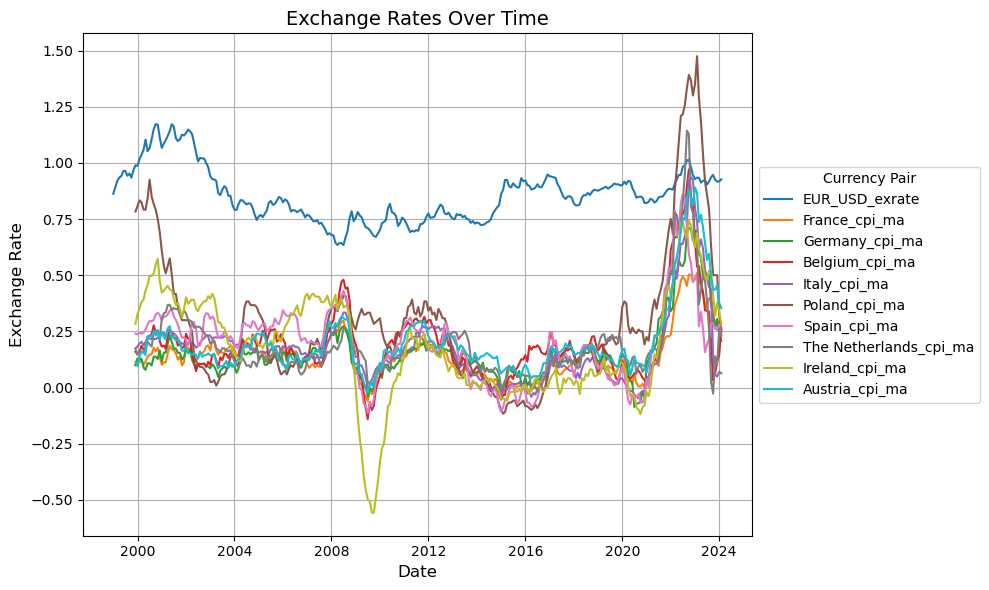

In [9]:
import matplotlib.pyplot as plt

# Subset for testing
exrate_cpis_ma_df = exrate_cpis_df[['date' ,'EUR_USD_exrate' , 'France_cpi_ma' , 'Germany_cpi_ma' , 'Belgium_cpi_ma' , 'Italy_cpi_ma' , 'Poland_cpi_ma' , 'Spain_cpi_ma' , 'The Netherlands_cpi_ma' , 'Ireland_cpi_ma' , 'Austria_cpi_ma']]
# Ensure the DataFrame is sorted by date for proper plotting
exrate_cpis_ma_df = exrate_cpis_ma_df.sort_values(by='date')

# Plot the data
plt.figure(figsize=(10, 6))
for column in exrate_cpis_ma_df.columns[1:]:  # Skip the 'date' column
    plt.plot(exrate_cpis_ma_df['date'], exrate_cpis_ma_df[column], label=column)

# Add plot details
plt.title("Exchange Rates Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Exchange Rate", fontsize=12)
plt.legend(title="Currency Pair", loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend to the right
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
# Ensure the DataFrame is sorted by date for proper plotting
France_df  = France_df .sort_values(by='date')

# Determine the number of subplots based on the number of series
num_series = len(France_df.columns) - 1  # Exclude the 'date' column

# Create subplots
fig, axes = plt.subplots(nrows=num_series, ncols=1, figsize=(10, 6 * num_series), sharex=True)

# Handle case when there's only one subplot
if num_series == 1:
    axes = [axes]

# Iterate over each series to create separate plots
for i, column in enumerate(France_df.columns[1:]):  # Skip the 'date' column
    axes[i].plot(France_df ['date'], France_df[column], label=column, color='tab:blue')
    axes[i].set_title(column, fontsize=14)
    axes[i].set_ylabel("Exchange Rate", fontsize=12)
    axes[i].grid(True)
    axes[i].legend(loc="upper left")

# Add shared x-axis label
axes[-1].set_xlabel("Date", fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'France_df' is not defined

In [97]:
exrate_cpis_df = exrate_cpis_df[exrate_cpis_df['date'] >= '1999-01-01' ]

In [104]:
exrate_cpis_df[['date' , 'USDEUR_exrate']].head(100)

,date,USDEUR_exrate
0,1954-04-01,NaN
1,1954-05-01,NaN
2,1954-06-01,NaN
3,1954-07-01,NaN
4,1954-08-01,NaN
...,...,...
95,1962-03-01,NaN
96,1962-04-01,NaN
97,1962-05-01,NaN
98,1962-06-01,NaN
